#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project2/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train = train.drop('subject', axis=1)
test = test.drop('subject', axis=1)


In [ ]:
print("데이터 로딩 완료!")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

데이터 로딩 완료!
Train shape: (638, 562)
Test shape: (798, 562)


#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
print("\n=== 데이터 Shape ===")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")


=== 데이터 Shape ===
Train: (638, 562)
Test: (798, 562)


In [ ]:
#전체 데이터의 상위 5개 행 확인
print("\n=== Train 상위 5개 행 ===")
display(train.head())


=== Train 상위 5개 행 ===


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
print("\n=== 기초 통계량 ===")
display(train.describe())


=== 기초 통계량 ===


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,...,637.000000,637.000000,637.000000,637.000000,637.000000,637.000000,637.000000,637.000000,637.000000,637.000000
mean,0.274279,-0.017008,-0.107553,-0.575070,-0.483116,-0.570844,-0.601676,-0.499853,-0.571936,-0.433931,...,0.113288,-0.333487,-0.656474,0.003679,-0.031113,-0.046908,-0.000236,-0.503661,0.075660,-0.043748
std,0.068835,0.053428,0.060730,0.454575,0.502442,0.429973,0.429918,0.485384,0.426739,0.549650,...,0.248393,0.295469,0.278984,0.345356,0.435034,0.609382,0.475821,0.495477,0.283461,0.281216
min,-0.503823,-0.594207,-0.560934,-0.999533,-0.998483,-0.999454,-0.999240,-0.998660,-0.999755,-0.948813,...,-0.649134,-0.878440,-0.983024,-0.945955,-0.975223,-0.996121,-0.971183,-0.991303,-0.940447,-0.920267
25%,0.263000,-0.026569,-0.121963,-0.991619,-0.972706,-0.979167,-0.992943,-0.973814,-0.978925,-0.934163,...,-0.042872,-0.535287,-0.848939,-0.137159,-0.318260,-0.569703,-0.367651,-0.804608,0.020664,-0.125803
50%,0.277451,-0.017192,-0.109123,-0.887533,-0.727317,-0.689054,-0.894071,-0.730509,-0.717382,-0.825600,...,0.119366,-0.380090,-0.727626,0.010497,-0.018309,-0.041439,-0.000134,-0.704115,0.191885,0.009808
75%,0.293703,-0.010001,-0.095626,-0.210679,-0.028059,-0.227661,-0.259275,-0.062056,-0.228635,0.006012,...,0.282156,-0.164851,-0.558498,0.166628,0.225681,0.422306,0.368886,-0.523517,0.252558,0.136733
max,0.632627,1.000000,0.719094,0.876942,0.916238,0.774026,0.852822,0.967664,0.717487,0.907994,...,0.788930,0.782821,0.705390,0.946651,0.959913,0.998702,0.996078,0.977344,0.478157,0.999014


In [ ]:
#전체 데이터의 모든 변수 확인
print("\n=== 데이터 정보 ===")
print(train.info())



=== 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 2.7+ MB
None


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
X = train.drop('Activity', axis=1)
y = train['Activity']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
display(f"y 클래스: {y.unique()}")


X shape: (638, 561)
y shape: (638,)


"y 클래스: ['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'\n 'SITTING' nan]"

### (2) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# NaN 값 처리
print("\n=== NaN 값 확인 ===")
print(f"X의 NaN 개수: {X.isnull().sum().sum()}")
print(f"y의 NaN 개수: {y.isnull().sum()}")

# X에 NaN이 있는 경우 처리
if X.isnull().sum().sum() > 0:
    print("\nX에 NaN 값이 있습니다.")
    # 방법1: 해당 행 제거
    nan_mask = ~X.isnull().any(axis=1)
    X = X[nan_mask]
    y = y[nan_mask]
    print(f"NaN 제거 후 shape: X={X.shape}, y={y.shape}")

    # 방법2: 평균값으로 채우기 (대안)
    # X = X.fillna(X.mean())

# y에 NaN이 있는 경우 처리
if y.isnull().sum() > 0:
    print("\ny에 NaN 값이 있습니다.")
    nan_mask = ~y.isnull()
    X = X[nan_mask]
    y = y[nan_mask]
    print(f"NaN 제거 후 shape: X={X.shape}, y={y.shape}")

print("\n✅ NaN 처리 완료!")


=== NaN 값 확인 ===
X의 NaN 개수: 225
y의 NaN 개수: 1

X에 NaN 값이 있습니다.
NaN 제거 후 shape: X=(637, 561), y=(637,)

✅ NaN 처리 완료!


In [ ]:
# 정수 인코딩 변환(LabelEncoder) - LabelEncoder 버전
le = LabelEncoder() #범주형(Categorical) 데이터를 수치형으로 인코딩(encoding)
y_encoded = le.fit_transform(y)
'''학습 데이터(train)는 fit과 transform을 모두 해야 함
→ 데이터 특성(평균, 표준편차 등)을 먼저 배워서 그걸 기준으로 변환
테스트 데이터(test)는 fit을 다시 하면 안 됨
→ 학습 데이터 기준으로 변환해야 하니까, fit된 상태에서 transform만 해야 함'''

print(f"\n인코딩 전: {y[:5].values}")
print(f"인코딩 후: {y_encoded[:5]}")


인코딩 전: ['STANDING' 'LAYING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS']
인코딩 후: [2 0 2 3 4]


In [ ]:
# 기존 레이블 저장
label_classes = le.classes_
print(f"\n레이블 클래스: {label_classes}")



레이블 클래스: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [ ]:
# 정수 인코딩 변환(LabelEncoder) - mapping 버전
encoder = LabelEncoder()
activity_map = {
    'LAYING': 0,
    'SITTING': 1,
    'STANDING': 2,
    'WALKING': 3,
    'WALKING_UPSTAIRS': 4,
    'WALKING_DOWNSTAIRS': 5
}
y_encoded = y.map(activity_map)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
unique, counts = np.unique(y_encoded, return_counts=True)
print("\n클래스별 샘플 수:")
for u, c in zip(unique, counts):
    print(f"클래스 {u} ({le.classes_[u]}): {c}개")

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded # stratify값을 target 값으로 지정해주면 target의 class 비율을 유지 한 채로 데이터 셋을 split
)
print("\nStratified split 적용")

print(f"\n=== 데이터 분할 결과 ===")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")



클래스별 샘플 수:
클래스 0 (LAYING): 113개
클래스 1 (SITTING): 102개
클래스 2 (STANDING): 118개
클래스 3 (WALKING): 106개
클래스 4 (WALKING_DOWNSTAIRS): 94개
클래스 5 (WALKING_UPSTAIRS): 104개

Stratified split 적용

=== 데이터 분할 결과 ===
X_train shape: (509, 561)
X_val shape: (128, 561)
y_train shape: (509,)
y_val shape: (128,)


### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
#스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지
#standard: 기본 스케일. 평균과 표준편차 사용
#MinMaxScaler:	최대/최소값이 각각 1, 0이 되도록 스케일링

# 방법 1: MinMaxScaler (0~1 범위)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)

print("1. MinMaxScaler 완료!")
print(f"   스케일링 전 범위: [{X_train.min().min():.4f}, {X_train.max().max():.4f}]")
print(f"   스케일링 후 범위: [{X_train_minmax.min():.4f}, {X_train_minmax.max():.4f}]")

1. MinMaxScaler 완료!
   스케일링 전 범위: [-1.0000, 1.0000]
   스케일링 후 범위: [0.0000, 1.0000]


In [ ]:
# 방법 2: StandardScaler (평균 0, 표준편차 1)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_val_standard = scaler_standard.transform(X_val)

print("\n2. StandardScaler 완료!")
print(f"   스케일링 후 평균: {X_train_standard.mean():.4f}")
print(f"   스케일링 후 표준편차: {X_train_standard.std():.4f}")


2. StandardScaler 완료!
   스케일링 후 평균: -0.0000
   스케일링 후 표준편차: 1.0000


In [ ]:
# 기본적으로 MinMaxScaler 사용 (나중에 비교)
X_train_scaled = X_train_minmax
X_val_scaled = X_val_minmax
current_scaler = scaler_minmax

print(f"\n현재 사용 중인 스케일러: MinMaxScaler")


현재 사용 중인 스케일러: MinMaxScaler


## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
# 입력 및 출력 차원 설정
input_dim = X_train_scaled.shape[1]
output_dim = len(label_classes)

print(f"\n=== 모델 설정 ===")
print(f"입력 차원: {input_dim}")
print(f"출력 차원: {output_dim}")

# 성능 저장용 데이터프레임
results = pd.DataFrame(columns=['Model', 'Scaler', 'Train_Acc', 'Val_Acc', 'Test_Acc']) # Scaler 종류를 추가



=== 모델 설정 ===
입력 차원: 561
출력 차원: 6




=== 모델1: Baseline (MinMax Scaler) ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1047 - loss: 1.8559 - val_accuracy: 0.3828 - val_loss: 1.4416
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4524 - loss: 1.3711 - val_accuracy: 0.5625 - val_loss: 1.2056
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5973 - loss: 1.1620 - val_accuracy: 0.6719 - val_loss: 1.0836
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6601 - loss: 1.0602 - val_accuracy: 0.7500 - val_loss: 1.0033
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7909 - loss: 0.9382 - val_accuracy: 0.7500 - val_loss: 0.9369
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8110 - loss: 0.8869 - val_accuracy: 0.7734 - val_loss: 0.8869
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8186 - loss: 0.8309 - val_accuracy: 0.7656 - val_loss: 0.8383
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8008 - loss: 0.7700 - val_accuracy: 0.7734 - val_loss

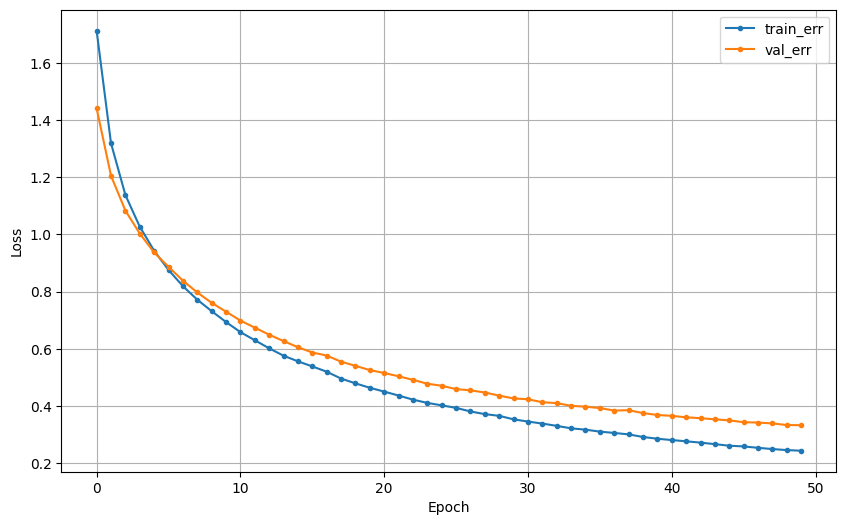


모델1 (MinMax) Train Accuracy: 0.9568
모델1 (MinMax) Val Accuracy: 0.8984


=== 모델1: Baseline (Standard Scaler) ===


/tmp/ipython-input-2903455558.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2302 - loss: 1.6731 - val_accuracy: 0.5469 - val_loss: 1.3442
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6006 - loss: 1.2593 - val_accuracy: 0.6328 - val_loss: 1.1355
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7209 - loss: 1.0898 - val_accuracy: 0.7344 - val_loss: 1.0205
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7725 - loss: 0.9813 - val_accuracy: 0.7188 - val_loss: 0.9489
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8096 - loss: 0.9078 - val_accuracy: 0.7422 - val_loss: 0.8857
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8128 - loss: 0.8395 - val_accuracy: 0.7969 - val_loss: 0.8353
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8641 - loss: 0.7853 - val_accuracy: 0.8047 - val_loss: 0.7926
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8479 - loss: 0.7337 - val_accuracy: 0.7891 - val_loss

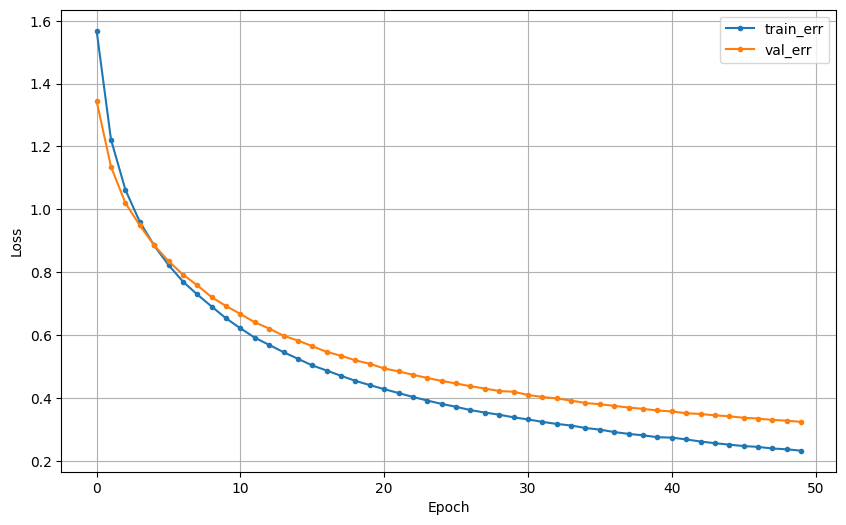


모델1 (Standard) Train Accuracy: 0.9391
모델1 (Standard) Val Accuracy: 0.8906


In [ ]:
# MinMaxScaler와 StandardScaler 모두 테스트
for scaler_name, X_tr, X_vl in [
    ('MinMax', X_train_minmax, X_val_minmax),
    ('Standard', X_train_standard, X_val_standard)
]:
    print(f"\n\n=== 모델1: Baseline ({scaler_name} Scaler) ===")

    # 모델 설계
    clear_session()
    '''clear_session() 함수는 현재 세션에 존재하는 모든 텐서 객체들을 삭제합니다.
    이 함수는 메모리 누수(memory leak)를 방지하고,
    모델을 여러 번 훈련할 때 이전에 사용되었던 가중치(weight) 등을 초기화하는 데 사용'''
    model1 = Sequential([
        Input(shape=(input_dim,)),
        Dense(output_dim, activation='softmax')
        # softmax: 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가짐, 다중 분류 모델에서 사용
    ])

    model1.summary()

    # 컴파일 및 학습
    model1.compile(
        optimizer=Adam(learning_rate=0.001), # Adam 학습률을 자동으로 조정하는 알고리즘으로, 현재 가장 많이 사용되는 최적화 알고리즘 중 하나
        loss='sparse_categorical_crossentropy', # 손실 함수는 모델의 예측값과 실제값의 차이를 계산합니다. 이 차이가 작을수록 모델이 좋은 성능, 다중 클래스 분류에서 y target이 정수일 때 이것 사용
        metrics=['accuracy'] # 평가 지표를 설정합니다. 모델의 성능을 평가할 때 사용됩니다. 회귀 문제에서는 mse, 분류 문제에서는 accuracy, precision, recall, f1-score 등이 사용
    )

    history1 = model1.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50, # Epoch 수가 너무 많아지면 모델이 훈련 데이터에만 과도하게 적응하여 새로운 데이터에 대한 성능이 떨어지는 오버피팅 현상이 발생할 수 있습니다
        batch_size=32,
        verbose=1
    )
    '''
    batch_size:
    한 번에 처리하는 데이터 샘플의 묶음 크기를 의미
    전체 학습 데이터셋이 너무 클 경우, 한 번에 모든 데이터를 학습시키는 것은
    메모리나 계산 시간 측면에서 비효율적일 수 있음
    따라서 전체 데이터셋을 여러 개의 작은 묶음(batch)으로 나누어 학습을 진행하게 됨
    '''

    # 학습곡선
    '''
    특정 업무나 지식을 처음 배울 때 걸리는 시간과 숙련도 사이의 관계를 그래프로 나타낸 것으로,
    반복할수록 숙련도가 높아지고 걸리는 시간이 줄어드는 현상을 보여줍니다
    '''
    print(f"\n{scaler_name} Scaler 학습곡선:")
    dl_history_plot(history1.history)

    # 예측 및 평가
    train_loss1, train_acc1 = model1.evaluate(X_tr, y_train, verbose=0)
    val_loss1, val_acc1 = model1.evaluate(X_vl, y_val, verbose=0)

    print(f"\n모델1 ({scaler_name}) Train Accuracy: {train_acc1:.4f}")
    print(f"모델1 ({scaler_name}) Val Accuracy: {val_acc1:.4f}")

    # 결과 저장
    results = pd.concat([results, pd.DataFrame({
        'Model': [f'Model1_Baseline'],
        'Scaler': [scaler_name],
        'Train_Acc': [train_acc1],
        'Val_Acc': [val_acc1],
        'Test_Acc': [None]
    })], ignore_index=True)


In [ ]:
# 최적 스케일러 선택 (모델1 결과 기반)
best_scaler_model1 = results[results['Model'] == 'Model1_Baseline'].sort_values('Val_Acc', ascending=False).iloc[0]['Scaler']
print(f"\n\n=== 모델1 최적 스케일러: {best_scaler_model1} ===")
print(f"이후 모델은 {best_scaler_model1} Scaler를 사용합니다.\n")

# 최적 스케일러 데이터 선택
if best_scaler_model1 == 'MinMax':
    X_train_scaled = X_train_minmax
    X_val_scaled = X_val_minmax
    current_scaler = scaler_minmax
else:
    X_train_scaled = X_train_standard
    X_val_scaled = X_val_standard
    current_scaler = scaler_standard



=== 모델1 최적 스케일러: MinMax ===
이후 모델은 MinMax Scaler를 사용합니다.



In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
print("\n=== 모델1 5회 반복 수행 ===")
model1_scores = []

for i in range(5):
    clear_session()

    model_temp = Sequential([
        Input(shape=(input_dim,)),
        Dense(output_dim, activation='softmax')
    ])

    model_temp.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model_temp.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    _, val_acc = model_temp.evaluate(X_val_scaled, y_val, verbose=0)
    model1_scores.append(val_acc)
    print(f"반복 {i+1}: Val Accuracy = {val_acc:.4f}")

print(f"\n모델1 평균 Val Accuracy: {np.mean(model1_scores):.4f} ± {np.std(model1_scores):.4f}")



=== 모델1 5회 반복 수행 ===
반복 1: Val Accuracy = 0.9297
반복 2: Val Accuracy = 0.8750
반복 3: Val Accuracy = 0.8984
반복 4: Val Accuracy = 0.9062
반복 5: Val Accuracy = 0.9141

모델1 평균 Val Accuracy: 0.9047 ± 0.0181


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
print("\n\n=== 모델2: Deep Network (5개 은닉층) ===")

# 모델 설계
clear_session()
model2 = Sequential([
    Input(shape=(input_dim,)),
    Dense(512, activation='relu'), # 기본적으로 은닉층에 사용하는 활성화 함수, 입력값이 0보다 작거나 같을 때는 항상 0을 출력하고, 0보다 크면 입력값과 동일한 출력값을 출력
    Dense(256, activation='relu'), # units 수가 너무 많으면 과적합(overfitting)이 발생할 수 있고, 너무 적으면 학습 능력이 떨어질 수 있음
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim, activation='softmax') # 분류 문제에서 마지막 Dense 레이어의 units 수는 분류하려는 클래스(class)의 수와 일치해야 함
])

model2.summary()



=== 모델2: Deep Network (5개 은닉층) ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,502 (1.76 MB)

 Trainable params: 462,502 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4071 - loss: 1.4993 - val_accuracy: 0.7188 - val_loss: 0.9400
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6412 - loss: 0.8523 - val_accuracy: 0.6797 - val_loss: 0.6537
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7753 - loss: 0.5991 - val_accuracy: 0.7734 - val_loss: 0.5004
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8267 - loss: 0.4450 - val_accuracy: 0.7344 - val_loss: 0.5120
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8907 - loss: 0.3032 - val_accuracy: 0.8359 - val_loss: 0.3506
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9429 - loss: 0.2203 - val_accuracy: 0.8828 - val_loss: 0.2825
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9017 - loss: 0.2561 - val_accuracy: 0.8906 - val_loss: 0.2931
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9280 - loss: 0.1989 - val_accuracy: 0.

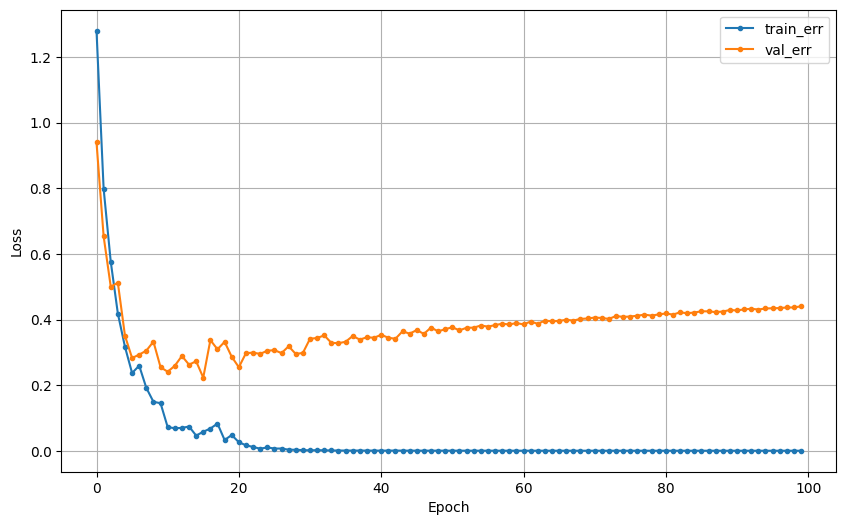

In [ ]:
# 학습곡선
dl_history_plot(history2.history)


In [ ]:
# 예측 및 평가
train_loss2, train_acc2 = model2.evaluate(X_train_scaled, y_train, verbose=0)
val_loss2, val_acc2 = model2.evaluate(X_val_scaled, y_val, verbose=0)

print(f"\n모델2 Train Accuracy: {train_acc2:.4f}")
print(f"모델2 Val Accuracy: {val_acc2:.4f}")


모델2 Train Accuracy: 1.0000
모델2 Val Accuracy: 0.9297


In [ ]:
# 결과 저장
results = pd.concat([results, pd.DataFrame({
    'Model': ['Model2_Deep'],
    'Scaler': [best_scaler_model1],
    'Train_Acc': [train_acc2],
    'Val_Acc': [val_acc2],
    'Test_Acc': [None]
})], ignore_index=True)


### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계
print("\n\n=== 모델3: Deep Network + Dropout ===")

# 모델 설계
clear_session()
model3 = Sequential([
    Input(shape=(input_dim,)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(output_dim, activation='softmax')
])
'''
신경망 학습 시 일부 뉴런을 임의로 비활성화하여 과적합을 방지하는 기법입니다.
학습 과정에서 매번 다른 뉴런 조합을 사용함으로써,
모델이 특정 뉴런에 과도하게 의존하는 것을 막고 더 일반화된 특징을 학습하도록 돕습니다
'''
model3.summary()



=== 모델3: Deep Network + Dropout ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,502 (1.76 MB)

 Trainable params: 462,502 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model3.compile(
    optimizer=Adam(learning_rate=0.001),  # 학습률 감소 -> 학습률이 너무 작을 경우 학습 속도가 매우 느려져 모델이 최적점에 도달하는 데 오랜 시간이 걸릴 가능성, 학습률이 너무 클 경우: 모델은 최적의 지점(최소값)을 지나쳐 버려(오버슈팅), 손실값이 오히려 커지거나 불안정한 학습
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32, # 배치 크기가 변하면 이에 맞춰 학습률을 조정해야 최적의 학습 결과를 얻을 수 있다는 연구 결과가 있습니다. 예를 들어, 배치 크기가 커지면 학습률도 함께 높여야 학습 효율성을 유지
    verbose=1
)
'''
큰 배치 크기와 높은 학습률 조합은 빠르게 수렴하지만 국소 최솟값에 갇힐 위험이 있고,
작은 배치 크기와 낮은 학습률 조합은 느리지만 안정적으로 탐색
'''

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1642 - loss: 1.8335 - val_accuracy: 0.5000 - val_loss: 1.7038
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2683 - loss: 1.6860 - val_accuracy: 0.3984 - val_loss: 1.5236
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2840 - loss: 1.5340 - val_accuracy: 0.5391 - val_loss: 1.3369
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3932 - loss: 1.4159 - val_accuracy: 0.5547 - val_loss: 1.1360
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5157 - loss: 1.2410 - val_accuracy: 0.6094 - val_loss: 0.9485
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5553 - loss: 1.0497 - val_accuracy: 0.6250 - val_loss: 0.8407
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6030 - loss: 0.9213 - val_accuracy: 0.7734 - val_loss: 0.7036
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6376 - loss: 0.8272 - val_accuracy: 0.6250 - val_loss:

'\n큰 배치 크기와 높은 학습률 조합은 빠르게 수렴하지만 국소 최솟값에 갇힐 위험이 있고,\n작은 배치 크기와 낮은 학습률 조합은 느리지만 안정적으로 탐색\n'

In [ ]:
# 학습곡선
dl_history_plot(history3.history)


In [ ]:
# 예측 및 평가
train_loss3, train_acc3 = model3.evaluate(X_train_scaled, y_train, verbose=0)
val_loss3, val_acc3 = model3.evaluate(X_val_scaled, y_val, verbose=0)

print(f"\n모델3 Train Accuracy: {train_acc3:.4f}")
print(f"모델3 Val Accuracy: {val_acc3:.4f}")


In [ ]:
results = pd.concat([results, pd.DataFrame({
    'Model': ['Model3_Dropout'],
    'Scaler': [best_scaler_model1],
    'Train_Acc': [train_acc3],
    'Val_Acc': [val_acc3],
    'Test_Acc': [None]
})], ignore_index=True)

### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계
print("\n\n=== 모델4: Optimized Model ===")

# 모델 설계
clear_session()
model4 = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(output_dim, activation='softmax')
])

model4.summary()

In [ ]:
# 컴파일 및 학습
model4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200, # Epoch 수가 너무 많아지면 모델이 훈련 데이터에만 과도하게 적응하여 새로운 데이터에 대한 성능이 떨어지는 오버피팅 현상이 발생할 수 있습니다
    batch_size=64,
    verbose=1
)

In [ ]:
# 학습곡선
dl_history_plot(history4.history)

In [ ]:
# 예측 및 평가
train_loss4, train_acc4 = model4.evaluate(X_train_scaled, y_train, verbose=0)
val_loss4, val_acc4 = model4.evaluate(X_val_scaled, y_val, verbose=0)

print(f"\n모델4 Train Accuracy: {train_acc4:.4f}")
print(f"모델4 Val Accuracy: {val_acc4:.4f}")

In [ ]:
results = pd.concat([results, pd.DataFrame({
    'Model': ['Model4_Optimized'],
    'Scaler': [best_scaler_model1],
    'Train_Acc': [train_acc4],
    'Val_Acc': [val_acc4],
    'Test_Acc': [None]
})], ignore_index=True)

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
# Test 데이터 전처리
print("\n\n=== Test 데이터 전처리 ===")

# x, y 분할
X_test = test.drop('Activity', axis=1)
y_test = test['Activity']

# NaN 값 확인 및 처리
print(f"X_test의 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"y_test의 NaN 개수: {y_test.isnull().sum()}")

if X_test.isnull().sum().sum() > 0:
    print("\n⚠️ X_test에 NaN 값이 있습니다. 처리 중...")
    nan_mask = ~X_test.isnull().any(axis=1)
    X_test = X_test[nan_mask]
    y_test = y_test[nan_mask]
    print(f"NaN 제거 후 shape: X_test={X_test.shape}, y_test={y_test.shape}")

if y_test.isnull().sum() > 0:
    print("\n⚠️ y_test에 NaN 값이 있습니다. 처리 중...")
    nan_mask = ~y_test.isnull()
    X_test = X_test[nan_mask]
    y_test = y_test[nan_mask]
    print(f"NaN 제거 후 shape: X_test={X_test.shape}, y_test={y_test.shape}")

# y: 정수 인코딩 적용
y_test_encoded = le.transform(y_test)

# x: 스케일링 적용
X_test_scaled = current_scaler.transform(X_test)

print(f"\nTest 데이터 스케일러: {best_scaler_model1}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test_encoded.shape}")

# Test 데이터에 대한 성능 측정
print("\n=== Test 데이터 성능 평가 ===")

models = [model1, model2, model3, model4]
model_names = ['Model1_Baseline', 'Model2_Deep', 'Model3_Dropout', 'Model4_Optimized']

for i, (model, name) in enumerate(zip(models, model_names)):
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
    print(f"{name} Test Accuracy: {test_acc:.4f}")

    # 결과 업데이트
    results.loc[results['Model'] == name, 'Test_Acc'] = test_acc

# 최종 결과 출력
print("\n=== 전체 모델 성능 비교 ===")
print(results.to_string(index=False))

# 스케일러별 비교 (모델1)
print("\n=== 스케일러 비교 (Model1 Baseline) ===")
scaler_comparison = results[results['Model'] == 'Model1_Baseline'][['Scaler', 'Val_Acc']].sort_values('Val_Acc', ascending=False)
print(scaler_comparison.to_string(index=False))

# 시각화 1: 전체 모델 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: 스케일러별 Model1 비교
model1_data = results[results['Model'] == 'Model1_Baseline']
axes[0].bar(model1_data['Scaler'], model1_data['Val_Acc'], alpha=0.8, color=['skyblue', 'lightcoral'])
axes[0].set_xlabel('Scaler')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Scaler Comparison (Model1 Baseline)')
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# 오른쪽: 전체 모델 비교
other_models = results[results['Model'] != 'Model1_Baseline']
x_pos = np.arange(len(other_models))
width = 0.25

axes[1].bar(x_pos - width, other_models['Train_Acc'], width, label='Train', alpha=0.8)
axes[1].bar(x_pos, other_models['Val_Acc'], width, label='Validation', alpha=0.8)
axes[1].bar(x_pos + width, other_models['Test_Acc'], width, label='Test', alpha=0.8)

axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Performance Comparison')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(other_models['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 최고 성능 모델 출력
best_model_idx = results['Val_Acc'].idxmax()
best_model = results.loc[best_model_idx]
print(f"\n=== 최고 성능 모델 ===")
print(f"모델: {best_model['Model']}")
print(f"Validation Accuracy: {best_model['Val_Acc']:.4f}")
print(f"Test Accuracy: {best_model['Test_Acc']:.4f}")

# 결과 저장
results.to_csv(path + 'model_results.csv', index=False)
print("\n모델 성능 결과가 저장되었습니다!")

In [ ]:
# test 데이터에 대한 성능 측정

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.